In [14]:
"""
    Constructing UJPY DJPY Portfolio
"""
## Asset Allocation Model
# Two Leveraged ETFs with target weight
# Case 1: No Rebalancing

import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, get_datetime, set_benchmark
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [15]:
def initialize(context):
    # ETFs and target weight
    context.securities = {
        'UJPY': 0.50,
        'DJPY': 0.50
    }
    
    # set_benchmark(False)
    set_benchmark(symbol('SPY'))

    context.has_ordered = False
    

In [16]:
def handle_data(context, data):
    # trading logic
    if not context.has_ordered:
        for sec, weight in context.securities.items():
            sym = symbol(sec)
            order_target_percent(sym, weight)
        # setting up a flag for holding a position
        context.has_ordered = True

In [17]:
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf

In [18]:
# Set start and end
#start = datetime(2010, 2, 12, 8, 15, 12, 0, pytz.UTC)
#end = datetime(2020, 7, 31, 8, 15, 12, 0, pytz.UTC)
start = pd.to_datetime('2018-01-12', utc=True)
end = pd.to_datetime('2020-08-19', utc=True)

# Fire off backtest
result = zipline.run_algorithm(
    start = start, 
    end = end, 
    initialize = initialize,
    handle_data = handle_data,
    capital_base = 10000, 
    data_frequency = 'daily', 
    bundle = 'etf_db_data'
)

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/empyrical/stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Entire data start date: 2018-01-12
Entire data end date: 2020-08-19


Backtest Months: 31


Performance statistics,Backtest
annual_return,-0.07
annual_volatility,0.11
sharpe_ratio,-0.63
calmar_ratio,-0.41
stability_of_timeseries,-0.91
max_drawdown,-0.17
omega_ratio,0.87
sortino_ratio,-0.87
skew,0.42
kurtosis,7.96


/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,17.36,2018-01-18,2020-08-13,NaT,NaN
1,0.00,2018-01-12,2018-01-12,2018-01-12,1
2,0.00,2018-01-12,2018-01-12,2018-01-12,1
3,0.00,2018-01-12,2018-01-12,2018-01-12,1
4,0.00,2018-01-12,2018-01-12,2018-01-12,1




[-0.014 -0.019]


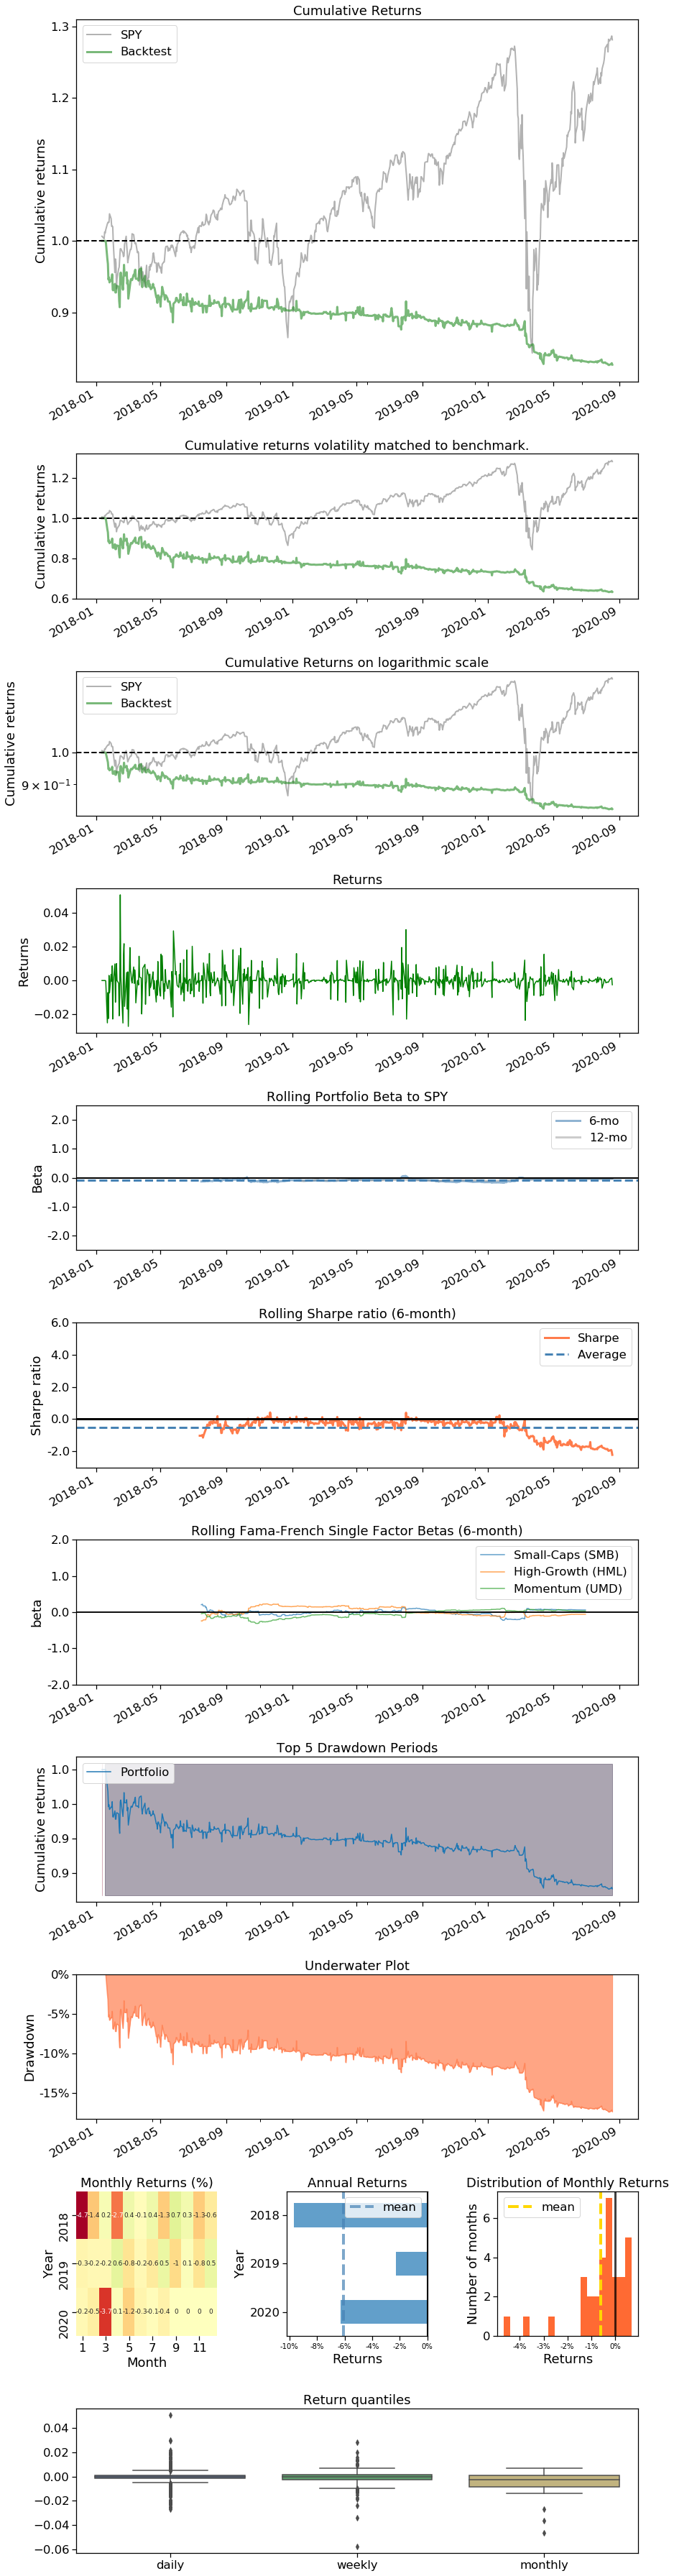

Stress Events,mean,min,max
New Normal,-0.03%,-2.71%,5.06%


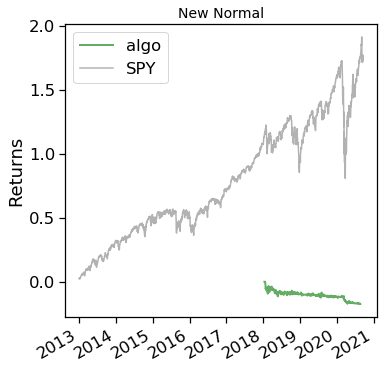

Top 10 long positions of all time,max
Equity(1903 [UJPY]),68.82%
Equity(328 [DJPY]),62.88%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Equity(1903 [UJPY]),68.82%
Equity(328 [DJPY]),62.88%


All positions ever held,max
Equity(1903 [UJPY]),68.82%
Equity(328 [DJPY]),62.88%


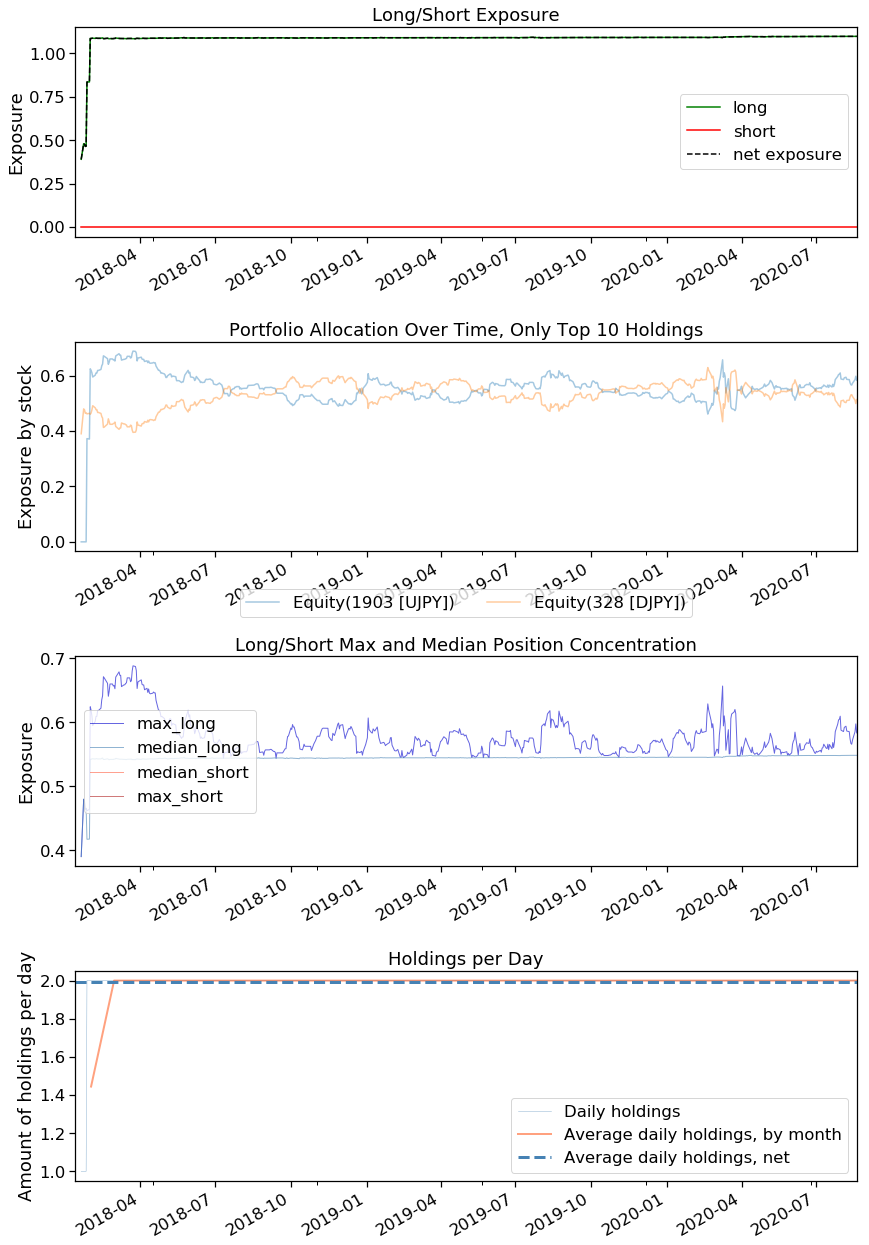

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/plotting.py:1210: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  **kwargs)


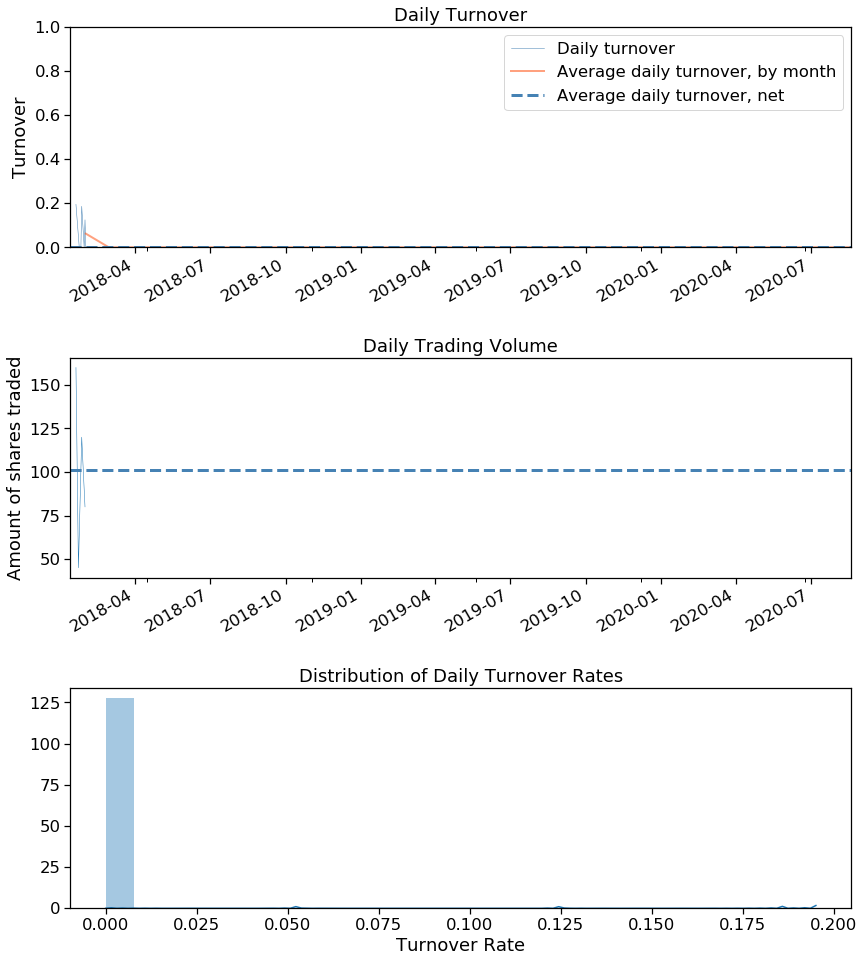

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/tears.py:590: UserWarning: Fewer than 5 round-trip trades made.
               Skipping round trip tearsheet.
  Skipping round trip tearsheet.""", UserWarning)


In [19]:
# Performance Analysis - Pyfolio Returns Tear Sheet
returns, positions, transactions, leverage = pf.utils.extract_rets_pos_txn_from_zipline(result)
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions, round_trips = True, 
                          benchmark_rets = None)
#pf.create_returns_tear_sheet(returns, benchmark_rets = None)

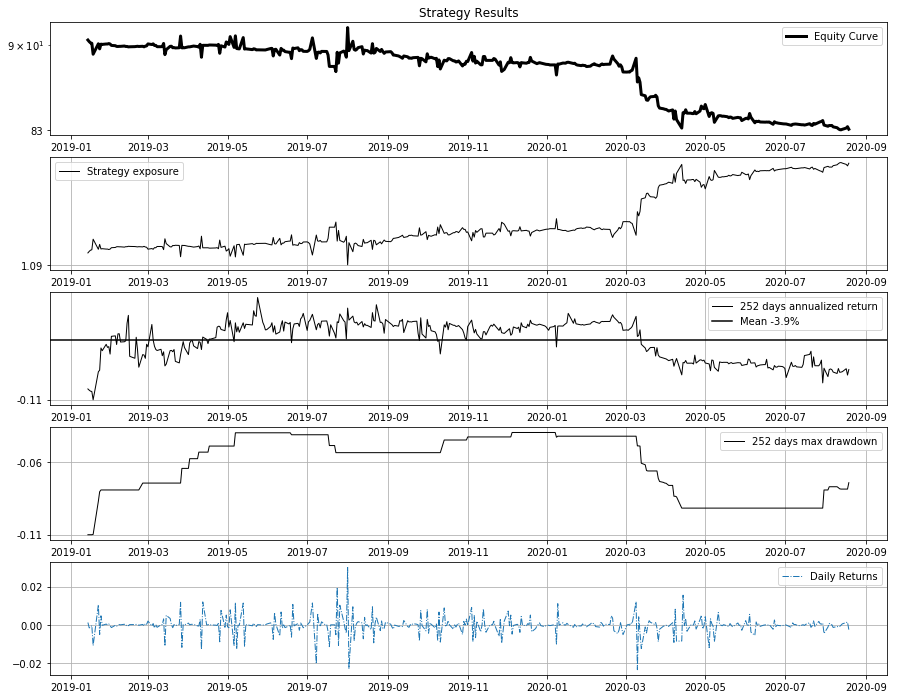

In [20]:
# Settings
window = 252
year_length = 252

# Copy the columns we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage', 'returns'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = result.portfolio_value.rolling(window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(15, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(511)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(512)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.01 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(513)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)
ax.axhline(df['annualized'].mean(), color='black', linewidth=1.5, 
           label='Mean {:0.1f}%'.format(df['annualized'].mean() * 100))

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.2 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(514)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.05 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fifth chart
ax = fig.add_subplot(515)
ax.plot(df['returns'], label = 'Daily Returns', linestyle='-.', linewidth = 1.0)
ax.legend()
ax.grid(True)

In [21]:
"""
    Monthly Time Return Table
"""


# Used for performance calculations
import empyrical as em

# Used for displaying HTML formatted content in notebook
from IPython.core.display import display, HTML

# Use Empyrical to aggregate on monthly and yearly periods
monthly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'monthly')
yearly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')

# Start off an HTML table for display
# HTML Table for display
table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>"""

# initialize
first_year = True
first_month = True
yr = 0
mnth = 0

# iterate over pandas series
for m, val in monthly_data.iteritems():
    yr = m[0]
    mnth = m[1]
    
    # first month of year, add year label to table
    if (first_month):
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False
    
    # pad empty months for first year if simulation starts later in year
    if (first_year):
        first_year = False
        if (mnth > 1):
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"
                
    # add monthly performance
    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)
    
    # check for 12th month, add annual return number
    if (mnth == 12):
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
        table += '</tr>\n<tr>\n'
        first_month = True
        
# pad empty months for last year
if (mnth != 12):
    for i in range(mnth + 1, 13):
        table +="<td align='right'><b>\n"
        if (i == 12):
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
            table += '</tr>\n<tr>\n'

# finalize table
table += '</tr>\n</tbody>\n</table>'

display(HTML(table))

In [22]:
"""
    Holding period table

    Shows percentage return if you started in January of a given year and held for certain number of full years.
    In Table you can see what would have happened if you strated this strategy at a given year, and kept trading it
    for number of years from that point. This can be a useful way to quickly get an overview of how the initial
    starting time sometimes can matter quite a lot for a trading model. The numbers show annualized return over
    the number of years displayed on the x-axis.
"""


def holding_period_map(df):
    
    # agreegate yearly data
    yr = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')
    df = pd.DataFrame(columns=range(1,len(yr)+1), index=yr.index)

    yr_start = 0
    
    # start table
    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Years</th>"
    
    # build first row
    for i in range(len(yr)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    # iterate years
    for the_year, value in yr.iteritems():
        # new table row
        table += "<tr><th>{}</th>".format(the_year)
        
        # iterate years held
        for yrs_held in (range(1, len(yr)+1)):
            if yrs_held   <= len(yr[yr_start:yr_start + yrs_held]):
                ret = em.annual_return(yr[yr_start:yr_start + yrs_held], 'yearly' )
                table += "<td>{:+.1f}</td>".format(ret * 100)
        table += "</tr>"    
        yr_start+=1
    return table

table = holding_period_map(df)
display(HTML(table))